In [1]:
from tqdm import tqdm
import random
import sys
sys.path.append("../")
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from cachingalgo.partial_observation.single_cache import CBMPS, CBSI, CBSILite, calculate_delta
from cachingalgo.request_generation.continuous import szipf

## Simulations of CB-MPS, CB-SI and CB-SILite

### Regret and hit rate analysis for varying cache_size

In [2]:
def reg_hit(L, cache, prob, req, algo, stepreq=None):
    """
    Calculates the regret and counters used at each time step 
    L: Library size
    cache: vector of cache sizes
    optcache: Optimal Cache of length equal to cache_size
    algo: 'si' or 'silite' or 'mps'
    stepreq: None - using data other than dynamic zipf data
    req: Requests
    Returns Regret, Counter Used at each time step and final cache
    """
    x = [i for i in range(req.shape[0])]
    Hit_rate = np.zeros(len(cache),)

    for it, j in tqdm(enumerate(cache)):
        regret = np.zeros((req.shape[0],))

        for _ in range(10):    
            optcache = np.argsort(prob)[::-1][:j]
            reg = 0
            hits = 0
            currcache = random.sample(range(1,L),j)
            if algo == 'mps':
                alg = CBMPS(L=L, cache_size=j)
            elif algo == 'si':
                delta, mu_c = calculate_delta(prob, cache_size=j)
                alg = CBSI(L=L, cache_size=j, delta=delta, mu_c=mu_c)
            elif algo == 'silite':
                delta, mu_c = calculate_delta(prob, cache_size=j)
                alg = CBSILite(L=L, cache_size=j, delta=delta, mu_c=mu_c)
            else:
                raise ValueError("arguments for algo should be 'mps' or 'si' or 'silite'")

            for i in range(req.shape[0]):
                request = req[i]

                lhs = 1 if request in optcache else 0

                if request in currcache:
                    rhs = 1
                    hits += 1 
                else:
                    rhs = 0

                if algo == 'silite':
                    alg.counterbank_update(request)
                    
                currcache = alg.currcache(Return=True)
                alg.update(request)


                reg += (lhs-rhs)
                regret[i] += reg

            Hit_rate[it] += (hits/req.shape[0])

        regret /= 10


        plt.plot(x, list(regret), label = f'C = {j}', linewidth=2)
        plt.xlabel('Time')
        plt.ylabel('Regret')

    plt.legend(loc= "best")
    plt.savefig(f"../plots/partial_observation/single_cache/cb{algo}cacher.eps")
    plt.show() 

    Hit_rate /= 10
    
    return {'hitrate':Hit_rate}

5it [02:15, 27.14s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


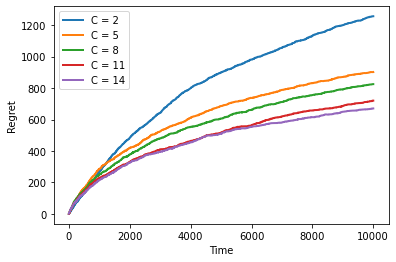

5it [01:52, 22.40s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


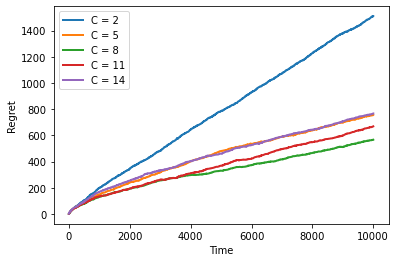

5it [00:45,  9.07s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


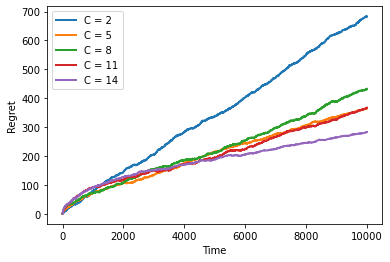

In [3]:
# Request Generation
szdata = szipf(count=10_000, a=1, L=100) # Static Zipf Data

# Defining Parameters
cache = [2, 5, 8, 11, 14]
L = szdata['prob'].shape[0]

CBMPS_sz = reg_hit(L=L, cache=cache, prob = szdata['prob'], req=szdata['req'], algo='mps')
CBSI_sz = reg_hit(L=L, cache=cache, prob = szdata['prob'], req=szdata['req'], algo='si')
CBSILite_sz = reg_hit(L=L, cache=cache, prob = szdata['prob'], req=szdata['req'], algo='silite')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


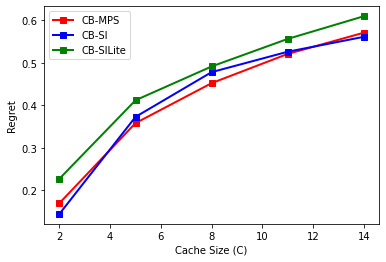

In [4]:
x = cache

# Static Zipf
plt.plot(x, CBMPS_sz['hitrate'], '-rs', label = 'CB-MPS', linewidth=2)
plt.plot(x, CBSI_sz['hitrate'], '-bs',label = 'CB-SI', linewidth=2)
plt.plot(x, CBSILite_sz['hitrate'], '-gs',label = 'CB-SILite', linewidth=2)

plt.xlabel("Cache Size (C)")
plt.ylabel("Regret")
plt.legend(loc="best")
plt.savefig('../plots/partial_observation/single_cache/cbcachehit.eps')
plt.show()

### Batch Analysis of CB-SI

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:26<00:00, 74.45s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


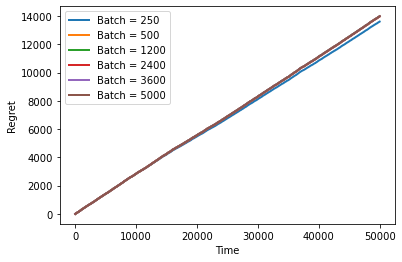

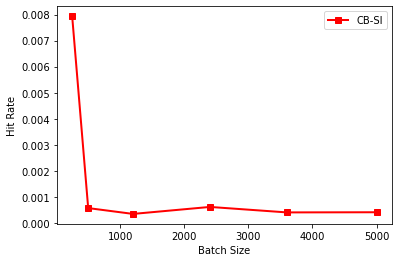

In [2]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=20_000) # Static Zipf Data

cache_size = 10
L = szdata['prob'].shape[0]
prob = szdata['prob']
req = szdata['req']

optcache = np.argsort(prob)[::-1][:cache_size]
reqshape = req.shape[0]

x = [i for i in range(reqshape)]
Batch = [250, 500, 1200, 2400, 3600, 5000] #Batch
Hit_rate_CBSI = np.zeros(len(Batch),)
delta, mu_c = calculate_delta(prob, cache_size)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for itr, j in enumerate(tqdm(Batch)):
    regret = np.zeros((reqshape,))
 
    for _ in range(10):
        alg = CBSI(L=L, cache_size=cache_size, delta=delta, mu_c=mu_c)      
        reg = 0
        hits = 0
        currcache = random.sample(range(1,L),cache_size)
        
        for i in range(reqshape):
            request = req[i]    

            lhs = 1 if request in optcache else 0
            if request in currcache:
                rhs = 1
                hits += 1
            else:
                rhs = 0

            if (i+1) % j == 0:
                currcache = alg.currcache(Return=True)
                alg.update(request)

            reg += (lhs-rhs)
            regret[i] += reg

        Hit_rate_CBSI[itr] += (hits/reqshape)

    regret /= 10
    
    ax1.plot(x,list(regret), label = f'Batch = {j}', linewidth=2)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Regret')


ax1.legend(loc= "best")
ax1.figure.savefig("../plots/partial_observation/single_cache/Batch/cbsibatchr.eps")

Hit_rate_CBSI /= 10

ax2.plot(Batch, Hit_rate_CBSI, '-rs', label = 'CB-SI', linewidth=2)
ax2.set_xlabel("Batch Size")
ax2.set_ylabel("Hit Rate")
ax2.legend()
ax2.figure.savefig('../plots/partial_observation/single_cache/Batch/cbsibatchh.eps')


### Window Analysis of CB-SILite

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [12:39<00:00, 126.59s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


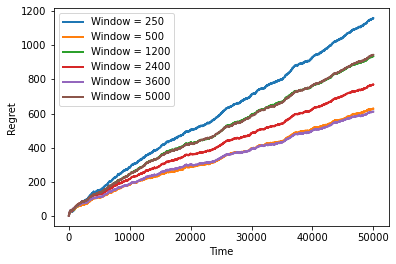

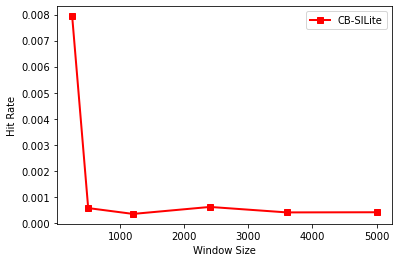

In [3]:
# Request Generation
szdata = szipf(count=50_000, a=1, L=20_000) # Static Zipf Data

cache_size = 10
L = szdata['prob'].shape[0]
prob = szdata['prob']

optcache = np.argsort(prob)[::-1][:cache_size]
reqshape = req.shape[0]

x = [i for i in range(reqshape)]
window = [250, 500, 1200, 2400, 3600, 5000] 
Hit_rate_CBSILite = np.zeros(len(Batch),)
delta, mu_c = calculate_delta(prob, cache_size)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for itr, j in enumerate(tqdm(window)):
    regret = np.zeros((reqshape,))
 
    for _ in range(10):
        alg = CBSILite(win=j,L=L, cache_size=cache_size, delta=delta, mu_c=mu_c)      
        reg = 0
        hits = 0
        currcache = random.sample(range(1,L),cache_size)
        
        for i in range(reqshape):
            request = req[i]    

            lhs = 1 if request in optcache else 0
            if request in currcache:
                rhs = 1
                hits += 1
            else:
                rhs = 0
            
            alg.counterbank_update(request)
            currcache = alg.currcache(Return=True)
            alg.update(request)

            reg += (lhs-rhs)
            regret[i] += reg

        Hit_rate_CBSILite[itr] += (hits/reqshape)

    regret /= 10
    
    ax1.plot(x,list(regret), label = f'Window = {j}', linewidth=2)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Regret')


ax1.legend(loc= "best")
ax1.figure.savefig("../plots/partial_observation/single_cache/Window/cbsilitewinr.eps")

Hit_rate_CBSILite /= 10

ax2.plot(Batch, Hit_rate_CBSI, '-rs', label = 'CB-SILite', linewidth=2)
ax2.set_xlabel("Window Size")
ax2.set_ylabel("Hit Rate")
ax2.legend()
ax2.figure.savefig('../plots/partial_observation/single_cache/Window/cbsilitewinh.eps')
